# Ecommerce text classification dataset

In [1]:
from collections import Counter
import warnings

# Gestione dei file di sistema
import time

import optuna
from sklearn.decomposition import PCA
# Manipolazione dei dati
import numpy as np
import pandas as pd

# Plot e visualizzazione
from wordcloud import WordCloud
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_theme()
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# NLP
import string, re, nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from string import punctuation
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from num2words import num2words
from spellchecker import SpellChecker
import spacy

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Scipy
import scipy

# Train-test split e cross validation
from sklearn.model_selection import train_test_split

# Classificatori
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score

# Il resto
import json
import gensim
from gensim.models import Word2Vec
from sklearn.decomposition import TruncatedSVD

c:\Users\LucaRemoLombardi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LucaRemoLombardi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LucaRemoLombardi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\LucaRemoLombardi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Analisi dati e grafici

### analisi primaria really simple

In [2]:
df = pd.read_csv(fr"esplorazione_dati.csv", 
    names = ['categoria', 'caratteristiche'])

In [3]:
# pd.set_option('display.max_rows', None)
df.head()

,categoria,caratteristiche
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [4]:
df.describe()

,categoria,caratteristiche
count,50425,50424
unique,4,27802
top,Household,Think & Grow Rich About the Author NAPOLEON HI...
freq,19313,30


In [5]:
df.head()

,categoria,caratteristiche
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [6]:
# quanti prodotti ci sono per categoria?
df.groupby('categoria').count()

,caratteristiche
categoria,
Books,11820
Clothing & Accessories,8670
Electronics,10621
Household,19313


In [7]:
print(pd.Series({"Numero di osservaazioni con valori mancanti: ": len(df) - len(df.dropna()),
                 "Numero di duplicati: ": df.duplicated().sum()}).to_string())

Numero di osservaazioni con valori mancanti:         1
Numero di duplicati:                             22622


In [8]:
df.dropna(inplace = True) # Droppiamo le osservazioni con valori mancanti
df.drop_duplicates(inplace = True) # Droppiamo le osservazioni con duplicati
df.reset_index(drop = True, inplace = True) 

In [9]:
df.describe()

,categoria,caratteristiche
count,27802,27802
unique,4,27802
top,Household,Paper Plane Design Framed Wall Hanging Motivat...
freq,10564,1


In [10]:
df['categoria'].unique()

array(['Household', 'Books', 'Clothing & Accessories', 'Electronics'],
      dtype=object)

In [11]:
# quanti prodotti ci sono per categoria?
df.groupby('categoria').count()

,caratteristiche
categoria,
Books,6256
Clothing & Accessories,5674
Electronics,5308
Household,10564


In [12]:
categoria_dizz = {'Electronics': 0, 'Household': 1, 'Books': 2, 'Clothing & Accessories': 3}
df.replace({'categoria': categoria_dizz}, inplace = True)

### Varie analisi con grafici

#### Grafici sulle parole più utilizzate

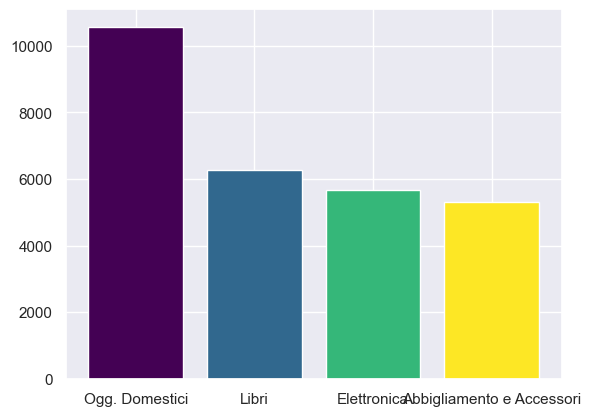

In [13]:
# Crea il grafico a barre
warnings.filterwarnings('ignore')
etichette = ['Ogg. Domestici', 'Libri', 'Elettronica', 'Abbigliamento e Accessori']
valori = df['categoria'].value_counts()
# Crea una mappa di colori (colormap)
colormap = plt.cm.get_cmap('viridis')

# Crea il grafico a barre con colori personalizzati
plt.bar(range(len(valori)), valori, color=colormap(np.linspace(0, 1, len(valori))))

# Imposta le etichette dell'asse x
plt.xticks(range(len(valori)), etichette)

# Mostra il grafico
plt.show()


In [14]:
data_e = df[df['categoria'] == 0] # Elettronici
data_d = df[df['categoria'] == 1] # Domestici
data_l = df[df['categoria'] == 2] # Libri
data_a = df[df['categoria'] == 3] # Abbigliamento ed Accessori

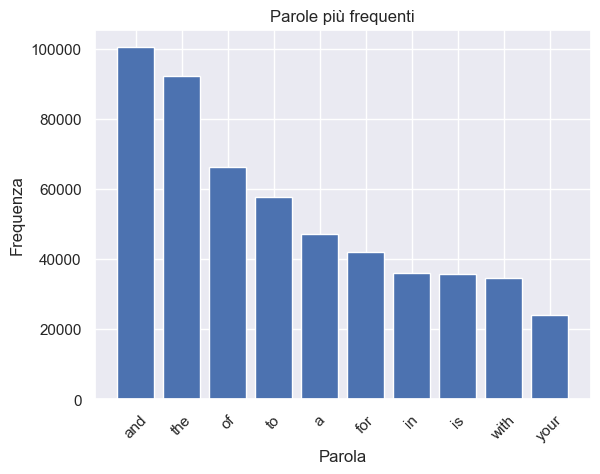

In [15]:
column_words = 'caratteristiche'  # Sostituisci 'nome_colonna' con il nome della colonna del DataFrame contenente le stringhe
all_words = ' '.join(df[column_words]).split()
word_counts = Counter(all_words)

top_words = dict(word_counts.most_common(10))
plt.bar(top_words.keys(), top_words.values())
plt.xlabel('Parola')
plt.ylabel('Frequenza')
plt.title('Parole più frequenti')
plt.xticks(rotation=45)
plt.show()

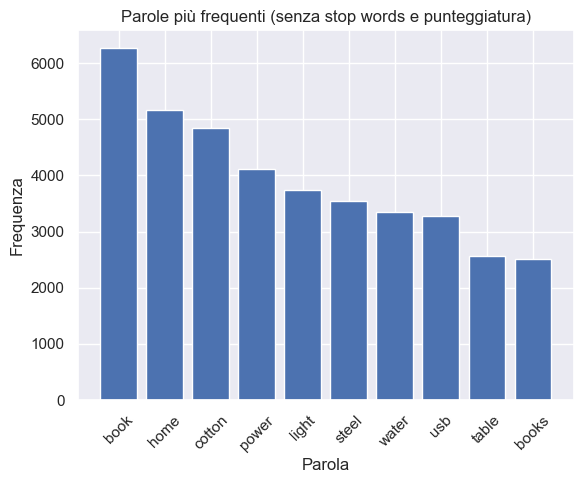

In [16]:
column_words = 'caratteristiche'
all_words = ' '.join(df[column_words]).lower()
all_words = re.sub(r'[^a-zA-Z0-9\s]', '', all_words)

tokens = word_tokenize(all_words)

stop_words = set(stopwords.words('english'))
# Aggiungo parola x e y e use alla lista di stop words
stop_words.update(['x', 'y', 'use', '1', 'fabric', 'products', 'stainless', 'years', 'makes', 'fit', 'set', 'white', 'wear', 'style', 'soft', 'look', 'long', 'life', 'design', 'material', 'designed', 'features', 'make', 'comes', 'used', 'author', 'black', 'color', 'high', 'best', 'made', 'one', 'quality', 'easy', 'perfect', 'product', 'also', 'size', 'two', 'new', 'first', 'many', 'well', 'great', 'good', 'like', 'would', 'get', 'much', 'even', 'time', 'could', 'bought', 'back', 'still', 'little', 'really', 'bought', 'back', 'still', 'litt'])
# aggiungi anche tutti i numeri in generale
stop_words.update([str(i) for i in range(0, 101)])
filtered_tokens = [word for word in tokens if word not in stop_words]

word_counts = Counter(filtered_tokens)

top_words = dict(word_counts.most_common(10))
plt.bar(top_words.keys(), top_words.values())
plt.xlabel('Parola')
plt.ylabel('Frequenza')
plt.title('Parole più frequenti (senza stop words e punteggiatura)')
plt.xticks(rotation=45)
plt.show()

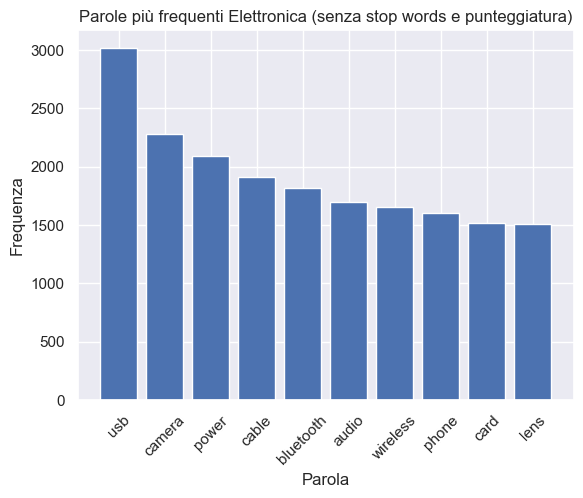

In [17]:
# elettronica

column_words = 'caratteristiche'
all_words = ' '.join(data_e[column_words]).lower()
all_words = re.sub(r'[^a-zA-Z0-9\s]', '', all_words)

tokens = word_tokenize(all_words)

stop_words = set(stopwords.words('english'))
# Aggiungo parola x e y e use alla lista di stop words
stop_words.update(['x', 'y', 'use', '1', 'set', 'made', 'high', 'black', 'one', 'product', 'also', 'size', 'two', 'new', 'first', 'many', 'well', 'great', 'good', 'like', 'would', 'get', 'much', 'even', 'time', 'could', 'bought', 'back', 'still', 'little', 'really', 'bought', 'back', 'still', 'litt'])
# aggiungi anche tutti i numeri in generale
stop_words.update([str(i) for i in range(0, 1000)])
filtered_tokens = [word for word in tokens if word not in stop_words]

word_counts = Counter(filtered_tokens)

top_words = dict(word_counts.most_common(10))
plt.bar(top_words.keys(), top_words.values())
plt.xlabel('Parola')
plt.ylabel('Frequenza')
plt.title('Parole più frequenti Elettronica (senza stop words e punteggiatura)')
plt.xticks(rotation=45)
plt.show()

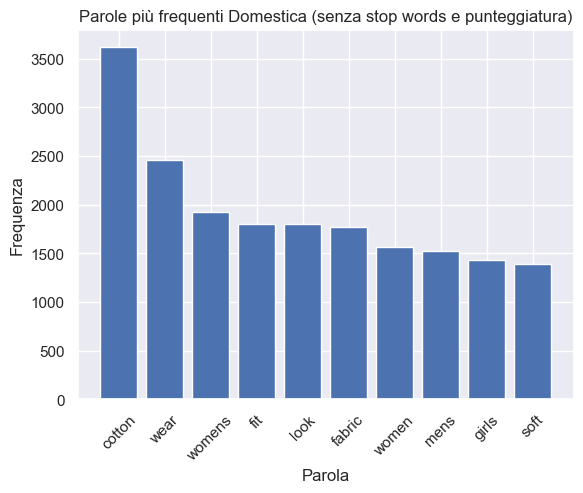

In [18]:
# Domestici

column_words = 'caratteristiche'
all_words = ' '.join(data_a[column_words]).lower()
all_words = re.sub(r'[^a-zA-Z0-9\s]', '', all_words)

tokens = word_tokenize(all_words)

stop_words = set(stopwords.words('english'))
# Aggiungo parola x e y e use alla lista di stop words
stop_words.update(['x', 'y', 'use', '1', 'set', 'durable', 'used', 'makes', 'best', 'storage', 'features', 'long', 'air', 'designed', 'clean', 'water', 'steel', 'finish', 'cm', 'products', 'stainless', 'white', 'comes', 'make', 'perfect', 'plastic', 'material', 'quality', 'design', 'color', 'easy', 'made', 'high', 'black', 'one', 'product', 'also', 'size', 'two', 'new', 'first', 'many', 'well', 'great', 'good', 'like', 'would', 'get', 'much', 'even', 'time', 'could', 'bought', 'back', 'still', 'little', 'really', 'bought', 'back', 'still', 'litt'])
# aggiungi anche tutti i numeri in generale
stop_words.update([str(i) for i in range(0, 1000)])
filtered_tokens = [word for word in tokens if word not in stop_words]

word_counts = Counter(filtered_tokens)

top_n = 10
top_words = dict(word_counts.most_common(top_n))
plt.bar(top_words.keys(), top_words.values())
plt.xlabel('Parola')
plt.ylabel('Frequenza')
plt.title('Parole più frequenti Domestica (senza stop words e punteggiatura)')
plt.xticks(rotation=45)
plt.show()

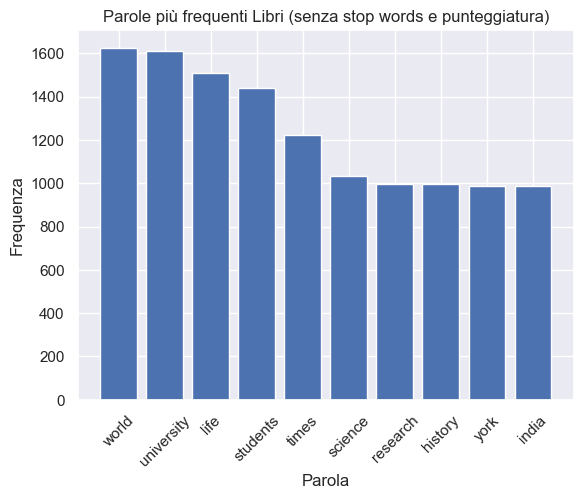

In [19]:
# Libri

column_words = 'caratteristiche'
all_words = ' '.join(data_l[column_words]).lower()
all_words = re.sub(r'[^a-zA-Z0-9\s]', '', all_words)

tokens = word_tokenize(all_words)

stop_words = set(stopwords.words('english'))
# Aggiungo parola x e y e use alla lista di stop words
stop_words.update(['x', 'y', 'use', '1', 'set', 'read', 'work', 'used', 'content', 'book', 'books', 'us', 'years', 'best', 'author', 'word', 'review', 'features', 'long', 'air', 'designed', 'clean', 'water', 'steel', 'finish', 'cm', 'products', 'stainless', 'white', 'comes', 'make', 'perfect', 'plastic', 'material', 'quality', 'design', 'color', 'easy', 'made', 'high', 'black', 'one', 'product', 'also', 'size', 'two', 'new', 'first', 'many', 'well', 'great', 'good', 'like', 'would', 'get', 'much', 'even', 'time', 'could', 'bought', 'back', 'still', 'little', 'really', 'bought', 'back', 'still', 'litt'])
# aggiungi anche tutti i numeri in generale
stop_words.update([str(i) for i in range(0, 1000)])
filtered_tokens = [word for word in tokens if word not in stop_words]

word_counts = Counter(filtered_tokens)

top_n = 10
top_words = dict(word_counts.most_common(top_n))
plt.bar(top_words.keys(), top_words.values())
plt.xlabel('Parola')
plt.ylabel('Frequenza')
plt.title('Parole più frequenti Libri (senza stop words e punteggiatura)')
plt.xticks(rotation=45)
plt.show()

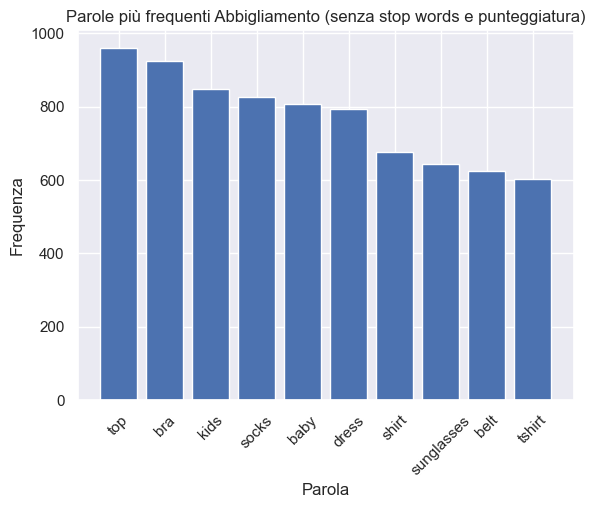

In [20]:
# Abbigliamento ed accessori

column_words = 'caratteristiche'
all_words = ' '.join(data_a[column_words]).lower()
all_words = re.sub(r'[^a-zA-Z0-9\s]', '', all_words)

tokens = word_tokenize(all_words)

stop_words = set(stopwords.words('english'))
# Aggiungo parola x e y e use alla lista di stop words
stop_words.update(['x', 'y', 'use', '1', 'girls', 'look', 'day', 'skin', 'printed', 'full', 'waist', 'fabric', 'brand', 'free', 'length', 'pair', 'boys', 'men', 'pack', 'stylish', 'fashion', 'casual', 'womens', 'women', 'wear', 'comfortable', 'comfort', 'style', 'fit', 'mens', 'soft', 'cotton', 'wears', 'set', 'read', 'work', 'used', 'content', 'book', 'books', 'us', 'years', 'best', 'author', 'word', 'review', 'features', 'long', 'air', 'designed', 'clean', 'water', 'steel', 'finish', 'cm', 'products', 'stainless', 'white', 'comes', 'make', 'perfect', 'plastic', 'material', 'quality', 'design', 'color', 'easy', 'made', 'high', 'black', 'one', 'product', 'also', 'size', 'two', 'new', 'first', 'many', 'well', 'great', 'good', 'like', 'would', 'get', 'much', 'even', 'time', 'could', 'bought', 'back', 'still', 'little', 'really', 'bought', 'back', 'still', 'litt'])
# aggiungi anche tutti i numeri in generale
stop_words.update([str(i) for i in range(0, 1000)])
filtered_tokens = [word for word in tokens if word not in stop_words]

word_counts = Counter(filtered_tokens)

top_n = 10
top_words = dict(word_counts.most_common(top_n))
plt.bar(top_words.keys(), top_words.values())
plt.xlabel('Parola')
plt.ylabel('Frequenza')
plt.title('Parole più frequenti Abbigliamento (senza stop words e punteggiatura)')
plt.xticks(rotation=45)
plt.show()

#### Seconda analisi 

In [21]:
def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, max_words=50, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

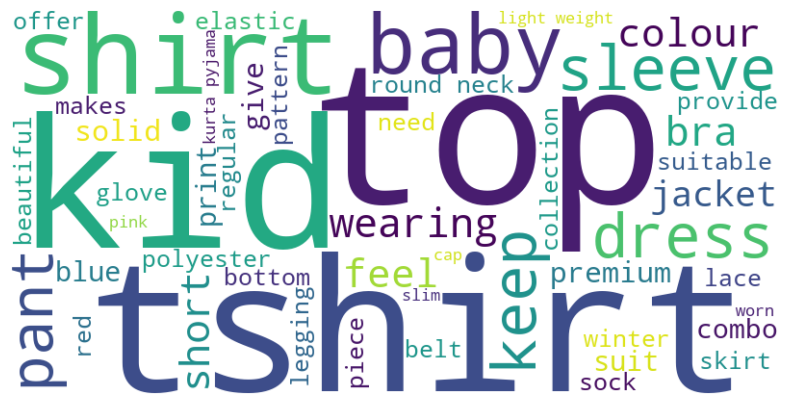

In [22]:
# Abbigliamento ed accessori
column_words = 'caratteristiche'
all_words = ' '.join(data_a[column_words]).lower()
all_words = re.sub(r'[^a-zA-Z0-9\s]', '', all_words)

tokens = word_tokenize(all_words)

stop_words = set(stopwords.words('english'))
# Aggiungo parola x e y e use alla lista di stop words
stop_words.update(['x', 'y', 'use', '1', 'girls', 'look', 'day', 'skin', 'printed', 'full', 'waist', 'fabric', 'brand', 'free', 'length', 'pair', 'boys', 'men', 'pack', 'stylish', 'fashion', 'casual', 'womens', 'women', 'wear', 'comfortable', 'comfort', 'style', 'fit', 'mens', 'soft', 'cotton', 'wears', 'set', 'read', 'work', 'used', 'content', 'book', 'books', 'us', 'years', 'best', 'author', 'word', 'review', 'features', 'long', 'air', 'designed', 'clean', 'water', 'steel', 'finish', 'cm', 'products', 'stainless', 'white', 'comes', 'make', 'perfect', 'plastic', 'material', 'quality', 'design', 'color', 'easy', 'made', 'high', 'black', 'one', 'product', 'also', 'size', 'two', 'new', 'first', 'many', 'well', 'great', 'good', 'like', 'would', 'get', 'much', 'even', 'time', 'could', 'bought', 'back', 'still', 'little', 'really', 'bought', 'back', 'still', 'litt'])
# aggiungi anche tutti i numeri in generale
stop_words.update([str(i) for i in range(0, 1000)])
text = [word for word in tokens if word not in stop_words]

text = ' '.join(text)
generate_wordcloud(text)

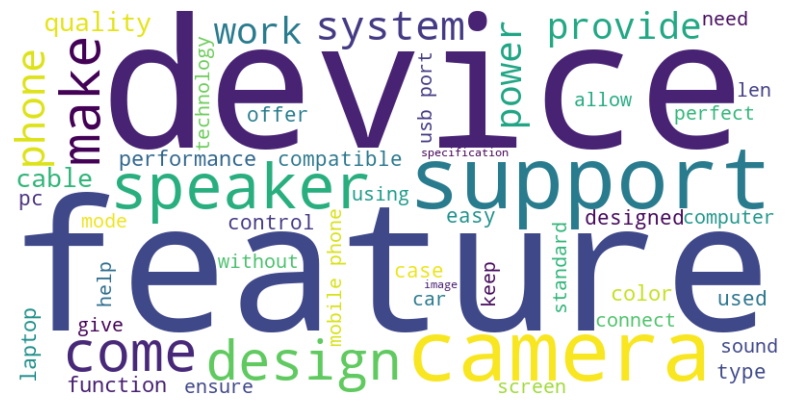

In [23]:
# elettronica

column_words = 'caratteristiche'
all_words = ' '.join(data_e[column_words]).lower()
all_words = re.sub(r'[^a-zA-Z0-9\s]', '', all_words)

tokens = word_tokenize(all_words)

stop_words = set(stopwords.words('english'))
# Aggiungo parola x e y e use alla lista di stop words
stop_words.update(['x', 'y', 'use', '1', 'set', 'made', 'high', 'black', 'one', 'product', 'also', 'size', 'two', 'new', 'first', 'many', 'well', 'great', 'good', 'like', 'would', 'get', 'much', 'even', 'time', 'could', 'bought', 'back', 'still', 'little', 'really', 'bought', 'back', 'still', 'litt'])
# aggiungi anche tutti i numeri in generale
stop_words.update([str(i) for i in range(0, 1000)])
text = [word for word in tokens if word not in stop_words]

text = ' '.join(text)
generate_wordcloud(text)

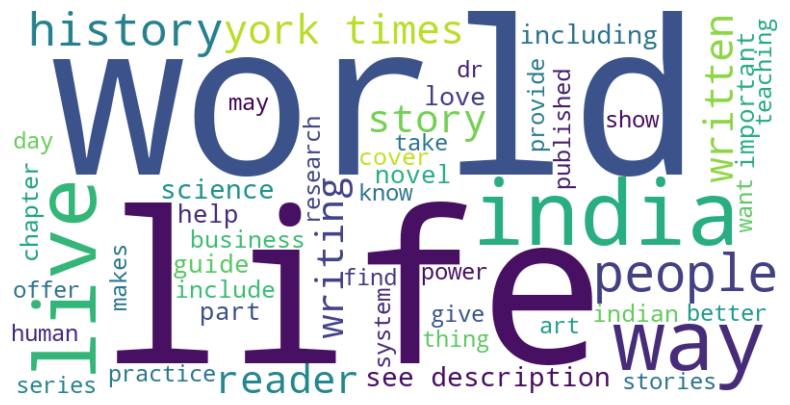

In [24]:
# Libri

column_words = 'caratteristiche'
all_words = ' '.join(data_l[column_words]).lower()
all_words = re.sub(r'[^a-zA-Z0-9\s]', '', all_words)

tokens = word_tokenize(all_words)

stop_words = set(stopwords.words('english'))
# Aggiungo parola x e y e use alla lista di stop words
stop_words.update(['x', 'y', 'use', '1', 'set', 'read', 'work', 'used', 'content', 'book', 'books', 'us', 'years', 'best', 'author', 'word', 'review', 'features', 'long', 'air', 'designed', 'clean', 'water', 'steel', 'finish', 'cm', 'products', 'stainless', 'white', 'comes', 'make', 'perfect', 'plastic', 'material', 'quality', 'design', 'color', 'easy', 'made', 'high', 'black', 'one', 'product', 'also', 'size', 'two', 'new', 'first', 'many', 'well', 'great', 'good', 'like', 'would', 'get', 'much', 'even', 'time', 'could', 'bought', 'back', 'still', 'little', 'really', 'bought', 'back', 'still', 'litt'])
# aggiungi anche tutti i numeri in generale
stop_words.update([str(i) for i in range(0, 1000)])
text = [word for word in tokens if word not in stop_words]

text = ' '.join(text)
generate_wordcloud(text)

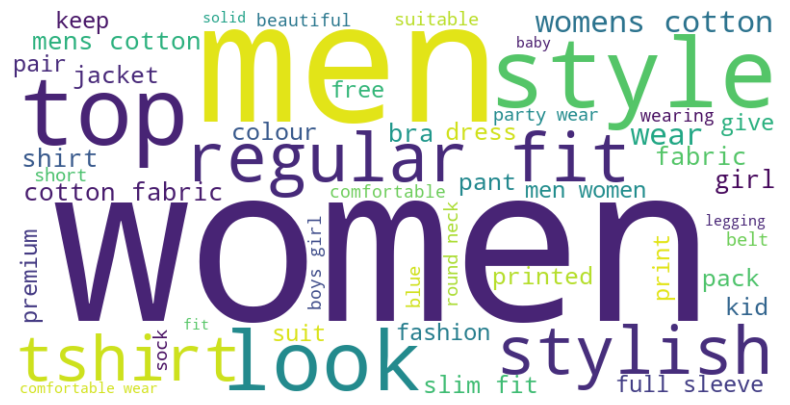

In [25]:
# Domestici

column_words = 'caratteristiche'
all_words = ' '.join(data_a[column_words]).lower()
all_words = re.sub(r'[^a-zA-Z0-9\s]', '', all_words)

tokens = word_tokenize(all_words)

stop_words = set(stopwords.words('english'))
# Aggiungo parola x e y e use alla lista di stop words
stop_words.update(['x', 'y', 'use', '1', 'set', 'durable', 'used', 'makes', 'best', 'storage', 'features', 'long', 'air', 'designed', 'clean', 'water', 'steel', 'finish', 'cm', 'products', 'stainless', 'white', 'comes', 'make', 'perfect', 'plastic', 'material', 'quality', 'design', 'color', 'easy', 'made', 'high', 'black', 'one', 'product', 'also', 'size', 'two', 'new', 'first', 'many', 'well', 'great', 'good', 'like', 'would', 'get', 'much', 'even', 'time', 'could', 'bought', 'back', 'still', 'little', 'really', 'bought', 'back', 'still', 'litt'])
# aggiungi anche tutti i numeri in generale
stop_words.update([str(i) for i in range(0, 1000)])
text = [word for word in tokens if word not in stop_words]

text = ' '.join(text)
generate_wordcloud(text)

## Test e Train split

In [26]:
# variabili feature e target split
X, y = df.drop('categoria', axis = 1), df['categoria']

# Train e test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40)
data_train = pd.concat([X_train, y_train], axis = 1)

data_test = pd.concat([X_test, y_test], axis = 1)

## Normalizzazione del testo

In [27]:
regexp = RegexpTokenizer("[\w']+")


#### Conversione in minuscolo

In [28]:
# ora posso mandare qualsiasi cosa dentro la funzione e la converte in lowercase

def convert_to_lowercase(text):
    return text.lower()

#### Rimozione spazi eccessivi

In [29]:
# così rimuovo inutili spazi eccessivi
def remove_whitespace(text):
    return text.strip()

#### Rimozione punteggiatura

In [30]:
# così rimuovo punteggiatura e caratteri speciali
def remove_punctuation(text):
    punct_str = string.punctuation
    punct_str = punct_str.replace("'", "") # rimoziona apostrofo
    return text.translate(str.maketrans("", "", punct_str))


#### Rimozione tag HTML


In [31]:
# Con questo rimuovo link mantenendo un eventuale testo presente
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)



#### Rimozione emoji

In [32]:
# con questa funzione posso rimuovere le emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags = re.UNICODE)
    return emoji_pattern.sub(r'', text)

#### rimozione http o wwww

In [33]:
# cose che iniziano con http o www
def remove_http(text):
    http = "https?://\S+|www\.\S+" # stringe con http o www
    pattern = r"({})".format(http)
    return re.sub(pattern, "", text)

#### Sostituzione acronimi

In [34]:
# tramite questo bel dataset riusciamo a convertire con semplicità tutte le orrende abbreviazione in inglese americano
acronyms_url = 'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/JSON/english_acronyms.json'
acronyms_dict = pd.read_json(acronyms_url, typ = 'series')

pd.DataFrame(acronyms_dict.items(), columns = ['acronym', 'original'])

# Lista di acronimi
acronyms_list = list(acronyms_dict.keys())

# Funzione per eliminare le contrazioni
def convert_acronyms(text):
    words = []
    for word in regexp.tokenize(text):
        if word in acronyms_list:
            words = words + acronyms_dict[word].split()
        else:
            words = words + word.split()
    
    text_converted = " ".join(words)
    return text_converted

#### Sostituzione contrazioni

In [35]:
# Traduce tutte le contrazioni della lingua inglese in forma estesa

contractions_url = 'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/JSON/english_contractions.json'
contractions_dict = pd.read_json(contractions_url, typ = 'series')

pd.DataFrame(contractions_dict.items(), columns = ['contraction', 'original'])

contractions_list = list(contractions_dict.keys())

def convert_contractions(text):
    words = []
    for word in regexp.tokenize(text):
        if word in contractions_list:
            words = words + contractions_dict[word].split()
        else:
            words = words + word.split()
    
    text_converted = " ".join(words)
    return text_converted

#### Rimozione delle Stop Words

In [36]:
stops = stopwords.words("english") # stopwords
addstops = ["among", "onto", "shall", "thrice", "thus", "twice", "unto", "us", "would"] # altre stop words
allstops = stops + addstops

print(allstops)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [37]:
def remove_stopwords(text):
    return " ".join([word for word in regexp.tokenize(text) if word not in allstops])

#### Correzione Spelling

In [38]:
spell = SpellChecker()

def pyspellchecker(text):
    word_list = regexp.tokenize(text)
    word_list_corrected = []
    for word in word_list:
        if word in spell.unknown(word_list):
            word_corrected = spell.correction(word)
            if word_corrected == None:
                word_list_corrected.append(word)
            else:
                word_list_corrected.append(word_corrected)
        else:
            word_list_corrected.append(word)
    text_corrected = " ".join(word_list_corrected)
    return text_corrected

text = "I'm goinng therre"
print("Input: {}".format(text))
print("Output: {}".format(pyspellchecker(text)))

Input: I'm goinng therre
Output: I'm going there


#### Generalizzazione del testo

In [39]:
# Generalizzazione del testo
spacy_lemmatizer = spacy.load("en_core_web_sm", disable = ['parser', 'ner'])


def text_lemmatizer(text):
    text_spacy = " ".join([token.lemma_ for token in spacy_lemmatizer(text)])
    
    return text_spacy
    

text = "Introducing lemmatization as an improvement over stemming"
print("Input: {}".format(text))
print("Output: {}".format(text_lemmatizer(text)))

Input: Introducing lemmatization as an improvement over stemming
Output: introduce lemmatization as an improvement over stem


#### Drop delle parole non alfabetiche

In [40]:
def discard_non_alpha(text):
    word_list_non_alpha = [word for word in regexp.tokenize(text) if word.isalpha()]
    text_non_alpha = " ".join(word_list_non_alpha)
    return text_non_alpha

text = "It is an ocean of thousands and 1000s of crowd"
print("Input: {}".format(text))
print("Output: {}".format(discard_non_alpha(text)))

Input: It is an ocean of thousands and 1000s of crowd
Output: It is an ocean of thousands and of crowd


#### Mantenimento parti importanti del testo

In [41]:
def keep_pos(text):
    tokens = regexp.tokenize(text)
    tokens_tagged = nltk.pos_tag(tokens)
    keep_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'FW', 'PRP', 'PRPS', 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WPS', 'WRB']
    keep_words = [x[0] for x in tokens_tagged if x[1] in keep_tags]
    return " ".join(keep_words)

text = "He arrived at seven o'clock on Wednesday evening"
print("Input: {}".format(text))
tokens = regexp.tokenize(text)
print("Tokens: {}".format(tokens))
tokens_tagged = nltk.pos_tag(tokens)
print("Tokens taggati: {}".format(tokens_tagged))
print("Output: {}".format(keep_pos(text)))

Input: He arrived at seven o'clock on Wednesday evening
Tokens: ['He', 'arrived', 'at', 'seven', "o'clock", 'on', 'Wednesday', 'evening']
Tokens taggati: [('He', 'PRP'), ('arrived', 'VBD'), ('at', 'IN'), ('seven', 'CD'), ("o'clock", 'NN'), ('on', 'IN'), ('Wednesday', 'NNP'), ('evening', 'NN')]
Output: He arrived o'clock Wednesday evening


#### Rimozione stop words aggiuntive

In [42]:
alphabets = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
prepositions = ["about", "above", "across", "after", "against", "among", "around", "at", "before", "behind", "below", "beside", "between", "by", "down", "during", "for", "from", "in", "inside", "into", "near", "of", "off", "on", "out", "over", "through", "to", "toward", "under", "up", "with"]
prepositions_less_common = ["aboard", "along", "amid", "as", "beneath", "beyond", "but", "concerning", "considering", "despite", "except", "following", "like", "minus", "onto", "outside", "per", "plus", "regarding", "round", "since", "than", "till", "underneath", "unlike", "until", "upon", "versus", "via", "within", "without"]
coordinating_conjunctions = ["and", "but", "for", "nor", "or", "so", "and", "yet"]
correlative_conjunctions = ["both", "and", "either", "or", "neither", "nor", "not", "only", "but", "whether", "or"]
subordinating_conjunctions = ["after", "although", "as", "as if", "as long as", "as much as", "as soon as", "as though", "because", "before", "by the time", "even if", "even though", "if", "in order that", "in case", "in the event that", "lest", "now that", "once", "only", "only if", "provided that", "since", "so", "supposing", "that", "than", "though", "till", "unless", "until", "when", "whenever", "where", "whereas", "wherever", "whether or not", "while"]
others = ["ã", "å", "ì", "û", "ûªm", "ûó", "ûò", "ìñ", "ûªre", "ûªve", "ûª", "ûªs", "ûówe"]
additional_stops = alphabets + prepositions + prepositions_less_common + coordinating_conjunctions + correlative_conjunctions + subordinating_conjunctions + others

def remove_additional_stopwords(text):
    return " ".join([word for word in regexp.tokenize(text) if word not in additional_stops])

#### Funzione che richiama tutte le altre

In [43]:
def text_normalizer(text):
    text = convert_to_lowercase(text)
    text = remove_whitespace(text)
    text = re.sub('\n' , '', text) # convertiamo il testo su una riga
    text = re.sub('\[.*?\]', '', text) # rimozione parentesi quadre
    text = remove_http(text)
    text = remove_punctuation(text)
    text = remove_html(text)
    text = remove_emoji(text)
    text = convert_acronyms(text)
    text = convert_contractions(text)
    text = remove_stopwords(text)
    text = text_lemmatizer(text) 
    text = discard_non_alpha(text)
    text = keep_pos(text)
    text = remove_additional_stopwords(text)
    return text

text = "We'll combine all functions into 1 SINGLE FUNCTION 🙂 & apply on @product #descriptions https://en.wikipedia.org/wiki/Text_normalization"
print("Input: {}".format(text))
print("Output: {}".format(text_normalizer(text)))

Input: We'll combine all functions into 1 SINGLE FUNCTION 🙂 & apply on @product #descriptions https://en.wikipedia.org/wiki/Text_normalization
Output: combine function function apply product description


#### Applicazione della funzione finale al nostro dataset

In [44]:
%%time
# normalizzazione del testo
data_train_norm, data_test_norm = pd.DataFrame(), pd.DataFrame()

data_train_norm['normalized description'] = data_train['caratteristiche'].apply(text_normalizer)
data_test_norm['normalized description'] = data_test['caratteristiche'].apply(text_normalizer)

data_train_norm['categoria'] = data_train['categoria']
data_test_norm['categoria'] = data_test['categoria']

data_train_norm

CPU times: total: 4min 34s
Wall time: 5min 4s


,normalized description,categoria
15525,approach acupuncture author author graduate al...,2
1536,nice leatherette office arm chair chair seat h...,1
21984,ekan fedora hat girl boy fedora hat hat man fe...,3
25056,concert showlightning controller lighting cont...,0
25213,marantz fully beltdrive premounted cartridge b...,0
...,...,...
23992,apple tablet inch gb wifi gold matter task pro...,0
27640,skin sticker super hero collection fit dell hp...,0
14501,challenger sale take control customer conversa...,2
14555,mathematics work book opinion class,2


## Model selection

### TF-IDF 

#### prima parte

In [45]:
# feature e label
X_train_norm, y_train = data_train_norm['normalized description'].tolist(), data_train_norm['categoria'].tolist()
X_test_norm, y_test = data_test_norm['normalized description'].tolist(), data_test_norm['categoria'].tolist()

In [46]:
# TF-IDF vettorizzazione
TfidfVec = TfidfVectorizer(ngram_range = (1, 1))
X_train_tfidf = TfidfVec.fit_transform(X_train_norm)
X_test_tfidf = TfidfVec.transform(X_test_norm)

In [47]:
# Classificatori
names = [
    "Logistic Regression",
    "KNN Classifier",
    "Linear SVM",
    "Random Forest",
]

models = [
    LogisticRegression(max_iter = 1000),
    KNeighborsClassifier(n_neighbors = 149, n_jobs = -1),
    svm.SVC(kernel = 'linear'),
    RandomForestClassifier(n_estimators = 100),
]

In [48]:
# Funzione per restituire un riepilogo dei modelli base usando il test set
def score(X_train, y_train, X_test, y_test, models, names):
    score_df, score_train, score_test = pd.DataFrame(), [], []
    x = time.time()
    for model in models:
        model.fit(X_train, y_train)
        y_train_pred, y_test_pred = model.predict(X_train), model.predict(X_test)
        score_train.append(accuracy_score(y_train, y_train_pred))
        score_test.append(accuracy_score(y_test, y_test_pred))
    
    score_df["Classifier"], score_df["Training accuracy"], score_df["Testing accuracy"] = names, score_train, score_test
    score_df.sort_values(by = 'Testing accuracy', ascending = False, inplace = True)
    return score_df

In [49]:
# Riepilogo dei modelli di base
score(X_train_tfidf, y_train, X_test_tfidf, y_test, names = names, models = models)

,Classifier,Training accuracy,Testing accuracy
2,Linear SVM,0.978193,0.951448
0,Logistic Regression,0.966818,0.942636
3,Random Forest,0.999955,0.923575
1,KNN Classifier,0.916101,0.908470


#### Iperparametri

In [50]:
def objective(trial):
    params_svm = {
        'kernel': trial.suggest_categorical('kernel', ['linear']),
        'C': trial.suggest_categorical('C', [0.1, 1, 10, 100])
    }

    svm_classifier = svm.SVC(**params_svm)
    svm_classifier.fit(X_train_tfidf, y_train)

    y_train_pred = svm_classifier.predict(X_train_tfidf)
    y_test_pred = svm_classifier.predict(X_test_tfidf)
    score_train = accuracy_score(y_train, y_train_pred)
    score_test = accuracy_score(y_test, y_test_pred)

    return score_test

study = optuna.create_study(direction='maximize', storage="sqlite:///study_TF-IDF.db", study_name="study_TF-IDF",load_if_exists=True)
study.optimize(objective, n_trials=100, n_jobs=-1)

# Recupero dei migliori parametri
best_params_svm = study.best_params
best_score_svm = study.best_value

# Addestramento del modello con i migliori parametri
best_model_svm = svm.SVC(**best_params_svm)
best_model_svm.fit(X_train_tfidf, y_train)

# Valutazione finale del modello
y_train_pred = best_model_svm.predict(X_train_tfidf)
y_test_pred = best_model_svm.predict(X_test_tfidf)
best_score_train = accuracy_score(y_train, y_train_pred)
best_score_test = accuracy_score(y_test, y_test_pred)

print(f"Miglior Modello: {best_model_svm}")
print(f"Miglior Parametri: {best_params_svm}")
print(f"Miglior Training Accuracy: {best_score_train}")
print(f"Miglior Testing Accuracy: {best_score_test}")


[I 2023-07-06 17:42:43,726] Using an existing study with name 'study_TF-IDF' instead of creating a new one.
[I 2023-07-06 17:48:46,551] Trial 20 finished with value: 0.9376011508721454 and parameters: {'C': 100, 'kernel': 'linear'}. Best is trial 1 with value: 0.9514475813702572.
[I 2023-07-06 17:48:47,094] Trial 17 finished with value: 0.9514475813702572 and parameters: {'C': 1, 'kernel': 'linear'}. Best is trial 1 with value: 0.9514475813702572.
[I 2023-07-06 17:48:51,714] Trial 16 finished with value: 0.9376011508721454 and parameters: {'C': 100, 'kernel': 'linear'}. Best is trial 1 with value: 0.9514475813702572.
[I 2023-07-06 17:48:53,738] Trial 18 finished with value: 0.9514475813702572 and parameters: {'C': 1, 'kernel': 'linear'}. Best is trial 1 with value: 0.9514475813702572.
[I 2023-07-06 17:48:55,673] Trial 19 finished with value: 0.9442546304621471 and parameters: {'C': 10, 'kernel': 'linear'}. Best is trial 1 with value: 0.9514475813702572.
[I 2023-07-06 17:48:56,756] Tria

Miglior Modello: SVC(C=1, kernel='linear')
Miglior Parametri: {'C': 1, 'kernel': 'linear'}
Miglior Training Accuracy: 0.9781934265545614
Miglior Testing Accuracy: 0.9514475813702572


In [52]:
study = optuna.load_study(storage="sqlite:///study_TF-IDF.db", study_name="study_TF-IDF")

In [54]:
# fittiamo il modello
best_model_svm.fit(X_train_tfidf, y_train)
y_test_pred = best_model_svm.predict(X_test_tfidf)
score_test = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy: {score_test}")

Test accuracy: 0.9514475813702572


### Word2vec

#### Partial Text Normalization

In [55]:
# Normalizzazione del testo per Word2Vec
for df in [data_train, data_test]:
    df['tokens'] = (df["caratteristiche"].apply(convert_to_lowercase)
                                     .apply(convert_contractions)
                                     .apply(regexp.tokenize))
data_train[['tokens', 'categoria']]

,tokens,categoria
15525,"[practical, approach, to, acupuncture, 1, abou...",2
1536,"[nice, goods, leatherette, office, arm, chair,...",1
21984,"[ekan, fashionable, fedora, hat, for, girls, b...",3
25056,"[techyshop, dmx512, professional, concert, sho...",0
25213,"[marantz, tt5005, fully, automatic, belt, driv...",0
...,...,...
23992,"[apple, ipad, pro, mpf12hn, a, tablet, 10, 5, ...",0
27640,"[printelligent, laptop, skins, stickers, super...",0
14501,"[the, challenger, sale, taking, control, of, t...",2
14555,"[international, mathematics, olympiad, work, b...",2


#### Word Embedding

In [56]:
# Carichiamo il modello pre trainato Word2Vec
# word2vec_path = fr"C:\Users\LucaRemoLombardi\Downloads\GoogleNews-vectors-negative300.bin"
# word2vec_path = fr"C:\Users\StefanoCarobene\Desktop\machine learning\GoogleNews-vectors-negative300.bin"
word2vec_path = fr"C:\Users\LucaRemoLombardi\Downloads\GoogleNews-vectors-negative300.bin"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary = True)

In [57]:
# Funzioni utili per Word2Vec
def get_average_word2vec(tokens_list, vector, generate_missing = False, k = 300):
    if len(tokens_list) < 1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis = 0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, tokens, generate_missing = False):
    embeddings = tokens.apply(lambda x: get_average_word2vec(x, vectors, generate_missing = generate_missing))
    return list(embeddings)

def plot_embedding(X, y):
    truncated_SVD = TruncatedSVD(n_components = 2)
    truncated_SVD.fit(X)
    scores = truncated_SVD.transform(X)
    color_mapper = {label:idx for idx, label in enumerate(set(y))}
    #color_column = [color_mapper[label] for label in y]
    colors = ['red', 'blue', 'green', 'black']
        
    plt.scatter(scores[:, 0], scores[:, 1], s = 8, alpha = 0.8, c = y, cmap = matplotlib.colors.ListedColormap(colors))
    red_patch = mpatches.Patch(color = 'red', label = 'Electronics')
    blue_patch = mpatches.Patch(color = 'blue', label = 'Household')
    green_patch = mpatches.Patch(color = 'green', label = 'Books')
    black_patch = mpatches.Patch(color = 'black', label = 'Clothing & Accessories')
    plt.legend(handles = [red_patch, blue_patch, green_patch, black_patch], prop = {"size": 12})

#### PCA

In [1]:
def plot_embedding(X, y):
    pca = PCA(n_components=2)
    reduced_X = pca.fit_transform(X)
    color_mapper = {label: idx for idx, label in enumerate(set(y))}
    colors = ['red', 'blue', 'green', 'black']

    plt.scatter(reduced_X[:, 0], reduced_X[:, 1], s=8, alpha=0.8, c=y, cmap=matplotlib.colors.ListedColormap(colors))
    red_patch = mpatches.Patch(color='red', label='Electronics')
    blue_patch = mpatches.Patch(color='blue', label='Household')
    green_patch = mpatches.Patch(color='green', label='Books')
    black_patch = mpatches.Patch(color='black', label='Clothing & Accessories')
    plt.legend(handles=[red_patch, blue_patch, green_patch, black_patch], prop={"size": 12})


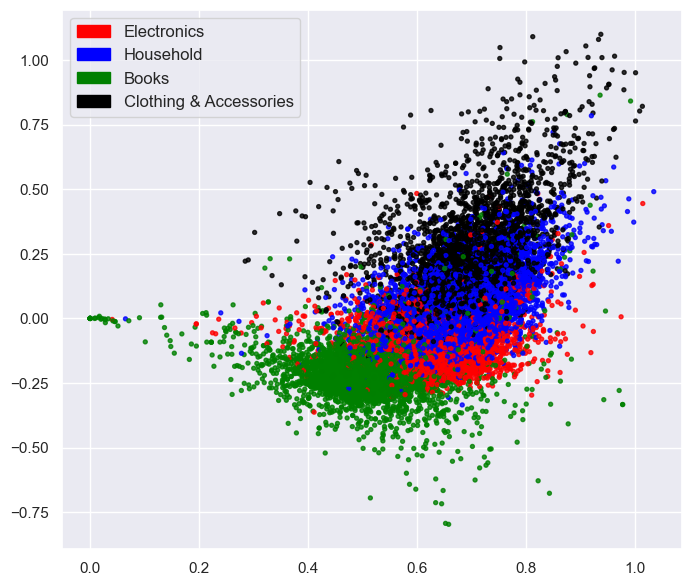

In [58]:
# Word2Vec embedding
X_train_embed = get_word2vec_embeddings(word2vec, data_train['tokens'])
X_test_embed = get_word2vec_embeddings(word2vec, data_test['tokens'])

fig = plt.figure(figsize = (8, 7))          
plot_embedding(X_train_embed, y_train)
plt.show()

In [60]:
# Convertiamo in matrice compressa a righe sparpagliate
X_train_w2v = scipy.sparse.csr_matrix(X_train_embed)
X_test_w2v = scipy.sparse.csr_matrix(X_test_embed)


#### Baseline Modeling

In [61]:
# Score dei modelli di base
score(X_train_w2v, y_train, X_test_w2v, y_test, names = names, models = models)

#### Hyperparameter tuning


In [ ]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0, 2),
        'seed': 40
    }

    xgb = XGBClassifier(**params)
    xgb.fit(X_train_w2v, y_train)
    y_train_pred = xgb.predict(X_train_w2v)
    y_test_pred = xgb.predict(X_test_w2v)
    score_test = accuracy_score(y_test, y_test_pred)
    
    return score_test

study = optuna.create_study(direction='maximize', storage = "sqlite:///xgb.db", study_name = "xgb",load_if_exists=True)
study.optimize(objective, n_trials=100,n_jobs=-1)

best_params_xgb = study.best_params
best_score_xgb = study.best_value

best_model_xgb = XGBClassifier(**best_params_xgb)
best_model_xgb.fit(X_train_w2v, y_train)


print(f"Miglior modello: {best_model_xgb}")
print(f"Migliori parametri: {best_params_xgb}")
print(f"Miglior Testing accuracy: {best_score_xgb}")

[I 2023-07-06 16:21:42,232] A new study created in RDB with name: xgb
[I 2023-07-06 16:25:46,967] Trial 0 finished with value: 0.9431859043509528 and parameters: {'learning_rate': 0.4812869159450642, 'min_child_weight': 4, 'n_estimators': 644, 'reg_lambda': 1.4924526016311743}. Best is trial 0 with value: 0.9431859043509528.


In [ ]:
study = optuna.load_study(study_name = "xgb", storage = "sqlite:///xgb.db")

## Final Prediction and Evaluation

In [ ]:
# Funzione per calcolare e stampare la matrice di confusione
def conf_mat(y_test, y_test_pred, figsize = (10, 8), font_scale = 1.2, annot_kws_size = 16):
    class_names = [0, 1, 2, 3] # ['Electronics', 'Household', 'Books', 'Clothing & Accessories']
    tick_marks_y = [0.5, 1.5, 2.5, 3.5]
    tick_marks_x = [0.5, 1.5, 2.5, 3.5]
    confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
    confusion_matrix_df = pd.DataFrame(confusion_matrix, range(4), range(4))
    plt.figure(figsize = figsize)
    sns.set(font_scale = font_scale) # label size
    plt.title("Matrice di confusione")
    sns.heatmap(confusion_matrix_df, annot = True, annot_kws = {"size": annot_kws_size}, fmt = 'd') # font size
    plt.yticks(tick_marks_y, class_names, rotation = 'vertical')
    plt.xticks(tick_marks_x, class_names, rotation = 'horizontal')
    plt.ylabel('Valore effettivo')
    plt.xlabel('Valore predetto')
    plt.grid(False)
    plt.show()

In [ ]:
# Miglior modello
if best_score_tfidf >= best_score_xgb:
    best_model, X_train_vec, X_test_vec = best_model_tfidf, X_train_tfidf, X_test_tfidf
else:
    best_model, X_train_vec, X_test_vec = best_model_xgb, X_train_w2v, X_test_w2v

Test accuracy    0.950378
 


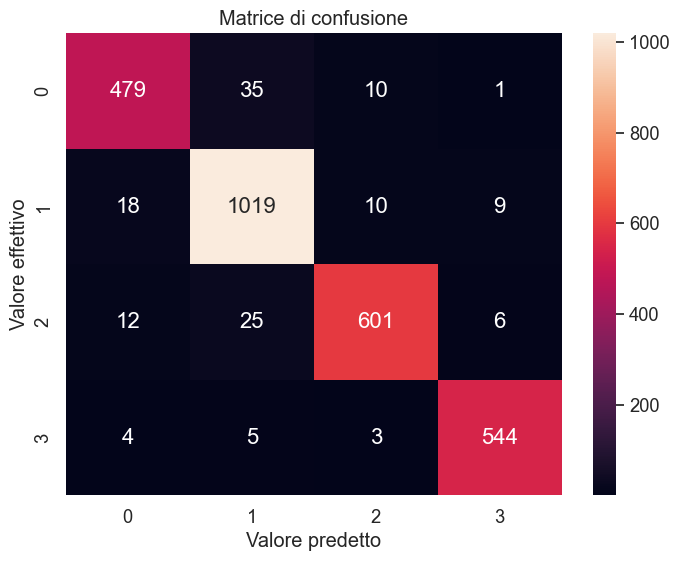

In [ ]:
# Predizione e evaluation sul test set
best_model.fit(X_train_vec, y_train)
y_test_pred = best_model.predict(X_test_vec)
score_test = accuracy_score(y_test, y_test_pred)
print(pd.Series({"Test accuracy": score_test}).to_string())
print(" ")
conf_mat(y_test, y_test_pred, figsize = (8, 6), font_scale = 1.2, annot_kws_size = 16) # Confusion matrix